# Implementation of Neural Network Classification on NSL-KDD Dataset
Using Method Described in *"Traffic Analysis Based Identification of Attacks"* found [here](http://cecs.louisville.edu/ry/Traffic.pdf).

Uses scikit-learn MLP learner to classify [NSL-KDD dataset](http://www.unb.ca/cic/research/datasets/nsl.html) and analyze results.

In [1]:
import pandas as pd
from sklearn.preprocessing import minmax_scale
from sklearn.neural_network import MLPClassifier

## Data Preprocessing
Define a data loading function, categorical variables are converted into numerical using categorical codes.

In [2]:
def load_data(file_path, cols=None):
    COL_NAMES = ["duration", "protocol_type", "service", "flag", "src_bytes",
                 "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                 "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                 "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                 "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                 "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                 "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                 "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                 "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                 "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels"]

    data = pd.read_csv(file_path, names=COL_NAMES, index_col=False)
    # Shuffle data
    data = data.sample(frac=1).reset_index(drop=True)
    NOM_IND = [1, 2, 3]
    BIN_IND = [6, 11, 13, 14, 20, 21]
    # Need to find the numerical columns for normalization
    NUM_IND = list(set(range(40)).difference(NOM_IND).difference(BIN_IND))
    # Convert nominal to category codes
    for num in NOM_IND:
        data.iloc[:, num] = data.iloc[:, num].astype('category')
        data.iloc[:, num] = data.iloc[:, num].cat.codes
    # Scale all numerical data to [0-1]
    data.iloc[:, NOM_IND] = minmax_scale(data.iloc[:, NOM_IND])
    data.iloc[:, NUM_IND] = minmax_scale(data.iloc[:, NUM_IND])
    labels = data['labels']
    del data['labels']
    return [data, labels]

## Neural Network Training and Testing
Define a function that trains the model and evaluates it on the test data, outputs accuracy on the training and test sets.

In [3]:
def train_clf(train_data, train_labels):
    bin_labels = train_labels.apply(lambda x: x if x =='normal' else 'anomaly')
    clf = MLPClassifier(hidden_layer_sizes=(20,), alpha=.7,
                        beta_1=.8, beta_2=.8)
    clf.fit(train_data, bin_labels)
    
    train_preds = clf.predict(train_data)
    
    TP = sum((train_preds == bin_labels) & (bin_labels == 'anomaly'))
    FP = sum((train_preds != bin_labels) & (bin_labels == 'normal'))
    
    TN = sum((train_preds == bin_labels) & (bin_labels == 'normal'))
    FN = sum((train_preds != bin_labels) & (bin_labels == 'anomaly'))
    
    train_acc = sum(train_preds == bin_labels)/len(train_preds)
    
    train_precision = TP/ (TP + FP) #Note: TP + FP = sum(train_preds == bin_labels)
    
    train_recall = TP/(TP + FN) #Note : TN + FN = sum(train_preds != bin_labels)
    
    train_f = 2 * train_precision * train_recall /(train_precision + train_recall)
    
    print("Accuracy on training set: {0:1%}".format(train_acc))
    print("Precision on training set: {0:1%}".format(train_precision))
    print("Recall on training set: {0:1%}".format(train_recall))
    print("F measure on training set: {0:1%}".format(train_f))

    return clf

In [4]:
def test_clf(test_data, test_labels, clf):
    bin_labels = test_labels.apply(lambda x: x if x =='normal' else 'anomaly')
    test_preds = clf.predict(test_data)
    
    TP = sum((test_preds == bin_labels) & (bin_labels == 'anomaly'))
    FP = sum((test_preds != bin_labels) & (bin_labels == 'normal'))
    
    TN = sum((test_preds == bin_labels) & (bin_labels == 'normal'))
    FN = sum((test_preds != bin_labels) & (bin_labels == 'anomaly'))
    
    test_acc = sum(test_preds == bin_labels)/len(test_preds)
    
    test_precision = TP/ (TP + FP) #Note: TP + FP = sum(train_preds == bin_labels)
    
    test_recall = TP/(TP + FN) #Note : TN + FN = sum(train_preds != bin_labels)
    
    test_f = 2 * test_precision * test_recall /(test_precision + test_recall)
    print("Accuracy on test set: {0:1%}".format(test_acc))
    print("Precision on test set: {0:1%}".format(test_precision))
    print("Recall on test set: {0:1%}".format(test_recall))
    print("F measure on test set: {0:1%}".format(test_f))
    return test_preds

# Training Classifier

In [5]:
train_data, train_labels = load_data('KDDTrain+.csv')
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,1.0,0.173913,0.9,3.116024e-08,5.725464e-08,0,0.0,0.0,0.0,...,1.000000,0.996078,1.00,0.01,0.00,0.00,0.0,0.0,0.0,0.0
1,0.0,0.5,0.782609,0.9,6.087116e-07,2.534472e-07,0,0.0,0.0,0.0,...,0.474510,0.709804,0.98,0.02,0.01,0.01,0.0,0.0,0.0,0.0
2,0.0,0.5,0.710145,0.5,0.000000e+00,0.000000e+00,0,0.0,0.0,0.0,...,1.000000,0.023529,0.02,0.06,0.00,0.00,1.0,1.0,0.0,0.0
3,0.0,0.0,0.202899,0.9,5.797253e-09,0.000000e+00,0,0.0,0.0,0.0,...,0.015686,0.047059,1.00,0.00,1.00,0.25,0.0,0.0,0.0,0.0
4,0.0,0.5,0.347826,0.9,2.239189e-07,2.459660e-06,0,0.0,0.0,0.0,...,0.541176,0.513725,0.95,0.01,0.01,0.00,0.0,0.0,0.0,0.0


In [6]:
clf = train_clf(train_data, train_labels)

Accuracy on training set: 96.697705%
Precision on training set: 97.982734%
Recall on training set: 94.857581%
F measure on training set: 96.394835%


# Testing

In [8]:
test_data, test_labels = load_data('KDDTest+.csv')
test_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,0.5,0.190476,0.2,0.000000,0.000000,0,0.0,0.0,0.000000,...,1.000000,0.003922,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00
1,0.0,0.5,0.349206,0.9,0.000868,0.006177,0,0.0,0.0,0.019802,...,1.000000,0.984314,0.98,0.01,0.00,0.00,0.0,0.0,0.01,0.01
2,0.0,0.5,0.714286,0.5,0.000000,0.000000,0,0.0,0.0,0.000000,...,1.000000,0.019608,0.02,0.07,0.00,0.00,1.0,1.0,0.00,0.00
3,0.0,0.5,0.349206,0.9,0.000003,0.000527,0,0.0,0.0,0.000000,...,0.329412,1.000000,1.00,0.00,0.01,0.02,0.0,0.0,0.00,0.00
4,0.0,0.5,0.349206,0.9,0.000004,0.009803,0,0.0,0.0,0.000000,...,1.000000,0.956863,0.96,0.01,0.00,0.00,0.0,0.0,0.00,0.00


In [9]:
test_preds = test_clf(test_data, test_labels, clf)

Accuracy on test set: 77.665898%
Precision on test set: 93.226164%
Recall on test set: 65.526377%
F measure on test set: 76.959685%


In [10]:
ATTACKS = {
    'normal': 'normal',

    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',

    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',

    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

test_cat_labels = test_labels.apply(lambda x: ATTACKS[x])
cats = {'U2R':[0, 0], 'DoS':[0, 0], 'R2L':[0, 0], 'Probe':[0, 0], 'normal':[0, 0]}
for cat, pred in zip(test_cat_labels, test_preds):
    cats[cat][pred=='normal'] += 1
print(cats)

for key, values in cats.items():
    print('\n' + key)
    total = sum(values)
    print('Total rows: {}'.format(total))
    if key == 'normal':
        correct = values[1]
    else:
        correct = values[0]
    print('Percent correctly classified: {:.1%}'.format(correct/total))

{'U2R': [115, 85], 'DoS': [5788, 1670], 'R2L': [359, 2395], 'Probe': [2147, 274], 'normal': [611, 9100]}

U2R
Total rows: 200
Percent correctly classified: 57.5%

DoS
Total rows: 7458
Percent correctly classified: 77.6%

R2L
Total rows: 2754
Percent correctly classified: 13.0%

Probe
Total rows: 2421
Percent correctly classified: 88.7%

normal
Total rows: 9711
Percent correctly classified: 93.7%


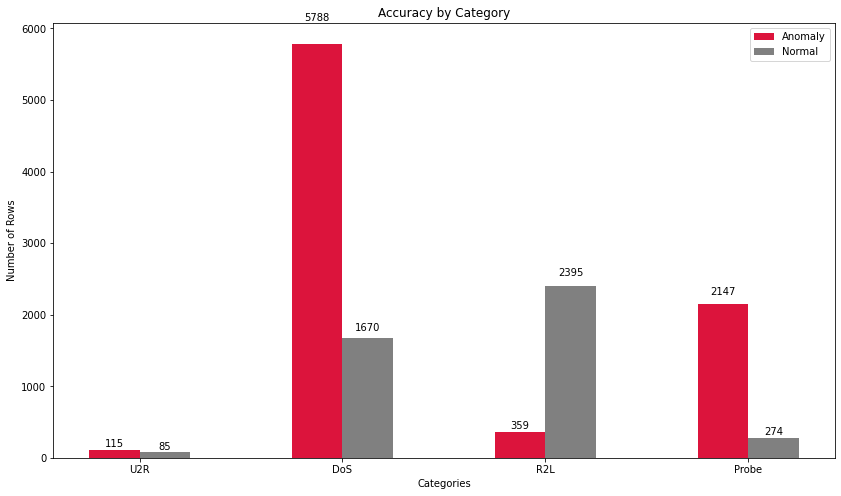

In [11]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
ind = np.arange(4)
width = .25
fig, ax = plt.subplots(figsize=(14,8))
del cats['normal']
anoms = [values[0] for key, values in cats.items()]
norms = [values[1] for key, values in cats.items()]
rect1 = ax.bar(ind, anoms, width, color='crimson')
rect2 = ax.bar(ind + width, norms, width, color='grey')
ax.set_ylabel('Number of Rows')
ax.set_title('Accuracy by Category')
ax.set_xlabel('Categories')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(cats.keys())
ax.legend((rect1[0], rect2[0]), ('Anomaly', 'Normal'))

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(rect1, ax)
autolabel(rect2, ax)

__Probe__ and __DoS__ have the highest accuracy, while __U2R__ is about even. __R2L__ classification is abysmal, however __normal__ labeling is almost _100%_, which means this classifier has a lot more false negatives than false positives.